## Imports

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from bitcoin_deep_learning.call_api import ApiCall
from bitcoin_deep_learning.model import RnnDlModel, LinearRegressionBaselineModel, DummyModel
from bitcoin_deep_learning.trainer import train, read_result
from bitcoin_deep_learning.cross_val import get_cross_XY
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import random
import joblib
%load_ext autoreload
%autoreload 2

## Getting data

In [4]:
train_df = ApiCall().read_local(data='train')#.drop(columns = '[%]_Bitcoin_growth_rate_on_Horizon=7')

In [5]:
X_train_list, Y_train_list, X_test_list,Y_test_list = get_cross_XY()

In [6]:
np.array(X_train_list).shape

(32, 263, 90, 31)

In [7]:
train_df.head(3)

,date,[AVG]_[NH]_mean_hash_rate,[+]_[NH]_Days_Till_Halving,[//]_[AV]_Stock-to-Flow_Ratio,[+]_[NH]_Circulating_Supply,[+]_[NH]_Issuance,[+]_[NH]_Number_of_Active_Addresses,[+]_[NH]_Mean_Block_Interval,[+]_[NH]_Number_of_Transactions,[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance,...,[//]_[AV]_Realized_Profits-to-Value_(RPV)_Ratio,fear_greed_value,[+]_[NH]_Number_of_Addresses_with_Balance_0.01 - 0.1,[+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1,[+]_[NH]_Number_of_Addresses_with_Balance_1 - 10,[+]_[NH]_Number_of_Addresses_with_Balance_10 - 100,[+]_[NH]_Number_of_Addresses_with_Balance_100 - 1k,[+]_[NH]_Number_of_Addresses_with_Balance_1k - 10k,[+]_[T]_Bitcoin_Price,[%]_Bitcoin_growth_rate_on_Horizon=7
0,2018-02-01,2.054109e+19,830,5642.903220,16839700.0,2000.0,842398,377,257504,27026398,...,0.003691,30,4226306,1722331,544769,132314,15779,1529,9014.026207,-0.235616
1,2018-02-02,2.170824e+19,829,5641.695528,16841800.0,2100.0,854253,385,235750,26955617,...,0.002557,15,4198274,1704275,543489,132213,15815,1521,8799.121911,-0.260491
2,2018-02-03,2.073919e+19,828,5641.015128,16843775.0,1975.0,714655,384,194733,26886977,...,0.001970,40,4173275,1692828,542447,132021,15812,1523,9208.459919,-0.230759


## Data viz exploration

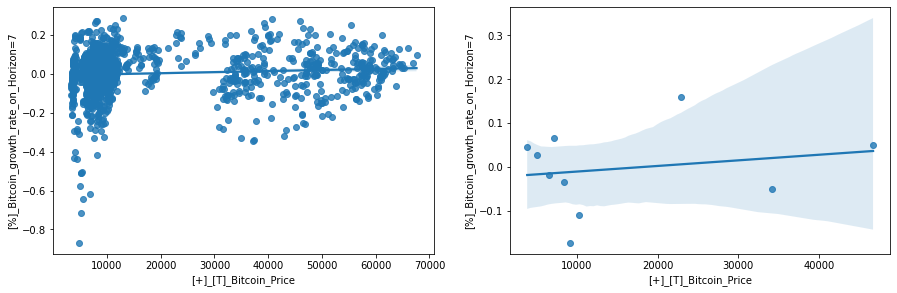

In [8]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.regplot(x='[+]_[T]_Bitcoin_Price', y='[%]_Bitcoin_growth_rate_on_Horizon=7', data=train_df, ci=95)
plt.subplot(2,2,2)
sns.regplot(x='[+]_[T]_Bitcoin_Price', y='[%]_Bitcoin_growth_rate_on_Horizon=7', data=train_df.sample(10, random_state=6), ci=95);

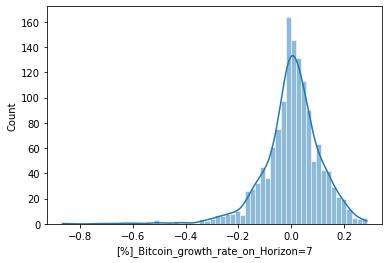

In [9]:
sns.histplot(train_df['[%]_Bitcoin_growth_rate_on_Horizon=7'], kde=True, edgecolor='w');

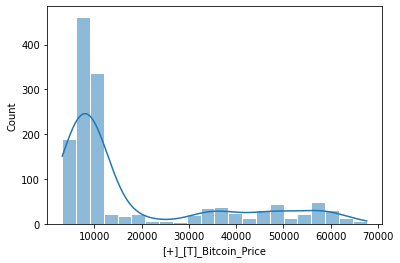

In [10]:
sns.histplot(train_df['[+]_[T]_Bitcoin_Price'], kde=True, edgecolor='w');

In [11]:
train_df['[%]_Bitcoin_growth_rate_on_Horizon=7'].std()

0.11173490347947096

In [12]:
train_df['[%]_Bitcoin_growth_rate_on_Horizon=7'].mean()

0.001917790190078434

## Exploration of ridge and lasso

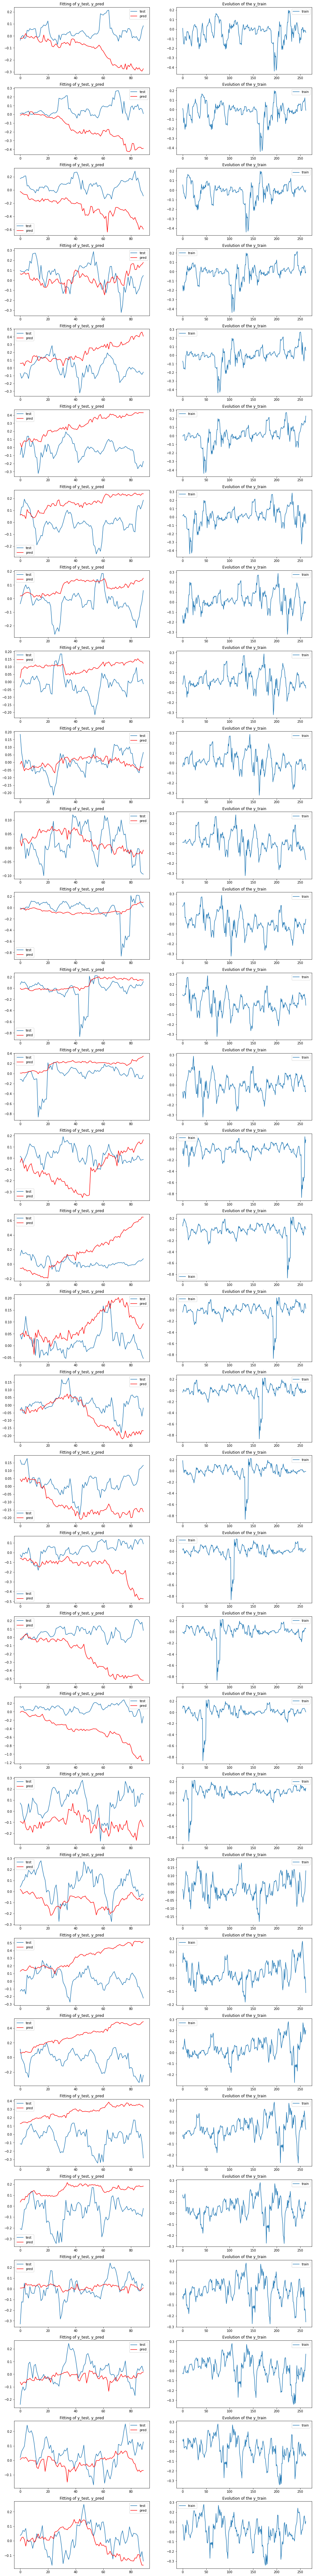

In [14]:
def plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, model):
    fig, axs = plt.subplots(nrows = len(X_train_list), ncols = 2, figsize = (17,150))
    for k in range(len(X_train_list)):
        X_train, y_train, X_test, y_test = X_train_list[k], Y_train_list[k], X_test_list[k], Y_test_list[k]
        #intuition too much regularization on the lasso
        model.set_model()
        model.fit(model.preproc(X_test, X_train)[1], y_train)
        y_pred = model.run(X_test, X_train, y_train)
        axs[k, 0].plot(y_test, label = 'test')
        axs[k, 0].plot(y_pred, color = 'r', label = 'pred')
        axs[k, 0].set_title('Fitting of y_test, y_pred')
        axs[k, 0].legend()
        axs[k, 1].plot(y_train, label = 'train')
        axs[k, 1].set_title('Evolution of the y_train')
        axs[k, 1].legend();

plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, LinearRegressionBaselineModel(alpha = 0.01 , l1_ratio = 0.001))

In [16]:
model_regression = LinearRegressionBaselineModel(alpha = 0.01 , l1_ratio = 0.001)
train(model_regression, train_df)
model_regression.model.coef_

100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.19it/s]

Training done


array([-0.02700587, -0.02545379, -0.11562652,  0.01792744,  0.02716201,
       -0.07667918, -0.04277892,  0.01168218,  0.01718915, -0.10093657,
       -0.04463744, -0.01987374, -0.06568812,  0.01423925, -0.0544017 ,
       -0.08884506,  0.03140889, -0.05237216, -0.09250752, -0.08274751,
       -0.04428104,  0.01178514,  0.00774667, -0.00370479,  0.03593648,
        0.01435675,  0.12051628,  0.04723806, -0.07914889,  0.01859832,
       -0.13595689])

## Analysing Coefs

### Elastic Net training

In [17]:
train(model_regression, train_df)
None

100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.60it/s]

Training done


### VIF index

In [18]:
train_df_nodates = train_df.copy().drop(columns = 'date')#.drop(columns = bucket_list)

In [19]:
train_df_nodates_scaled = train_df_nodates.copy()

for feature in train_df_nodates_scaled.columns:
    mu = train_df_nodates[feature].mean()
    sigma = train_df_nodates[feature].std()
    train_df_nodates_scaled[feature] = train_df_nodates_scaled[feature].apply(lambda x: (x-mu)/sigma)

In [20]:
df = pd.DataFrame()

df["features"] = train_df_nodates_scaled.columns

df["vif_index"] = [vif(train_df_nodates_scaled.values, i) for i in range(train_df_nodates_scaled.shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2).reset_index(drop = True)

/Users/chbro/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,features,vif_index
0,[%]_Bitcoin_growth_rate_on_Horizon=7.1,inf
1,[%]_Bitcoin_growth_rate_on_Horizon=7,inf
2,[+]_[NH]_Circulating_Supply,536.34
3,[$]_[BSB]_Realized_Price,470.79
4,[//]_[AV]_Stock-to-Flow_Ratio,292.45
5,[+]_[NH]_Number_of_Addresses_with_Balance_0.01...,272.90
6,[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_B...,256.78
7,[+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1,236.86
8,[+]_[T]_Bitcoin_Price,174.84
9,[//]_[AV]_Market_Value_to_Realized_Value_Ratio...,146.87


### Coef matrix

In [34]:
len(train_df.columns)

34

In [35]:
len(model_regression.model.coef_)

32

In [21]:
coeff_matrix = pd.DataFrame(zip(train_df.columns,model_regression.model.coef_))
coeff_matrix = coeff_matrix.rename(columns={0: "features", 1: "coeff"})
coeff_matrix_absolute = coeff_matrix.copy()
coeff_matrix_absolute['coeff abs'] = coeff_matrix['coeff'].apply(abs)
coeff_matrix_absolute = coeff_matrix_absolute.drop(columns = 'coeff')
coeff_matrix_absolute.sort_values(by = 'coeff abs', ascending = False).reset_index(drop = True)

,features,coeff abs
0,[+]_[NH]_Number_of_Addresses_with_Balance_10 -...,0.026993
1,date,0.024846
2,[+]_[NH]_Number_of_Addresses_with_Balance_1k -...,0.020539
3,[+]_[NH]_Issuance,0.019811
4,[%]_[BSB]_Percent_Balance_on_Exchanges_-_All_E...,0.018352
5,[$]_[BSB]_Net_Unrealized_Profit/Loss_(NUPL),0.018348
6,[+]_[NH]_Days_Till_Halving,0.017226
7,[$]_[BSB]_Realized_Price,0.015904
8,[//]_[AV]_Market_Value_to_Realized_Value_Ratio...,0.015739
9,[+]_[NH]_Number_of_Addresses_with_Balance_0.01...,0.015637


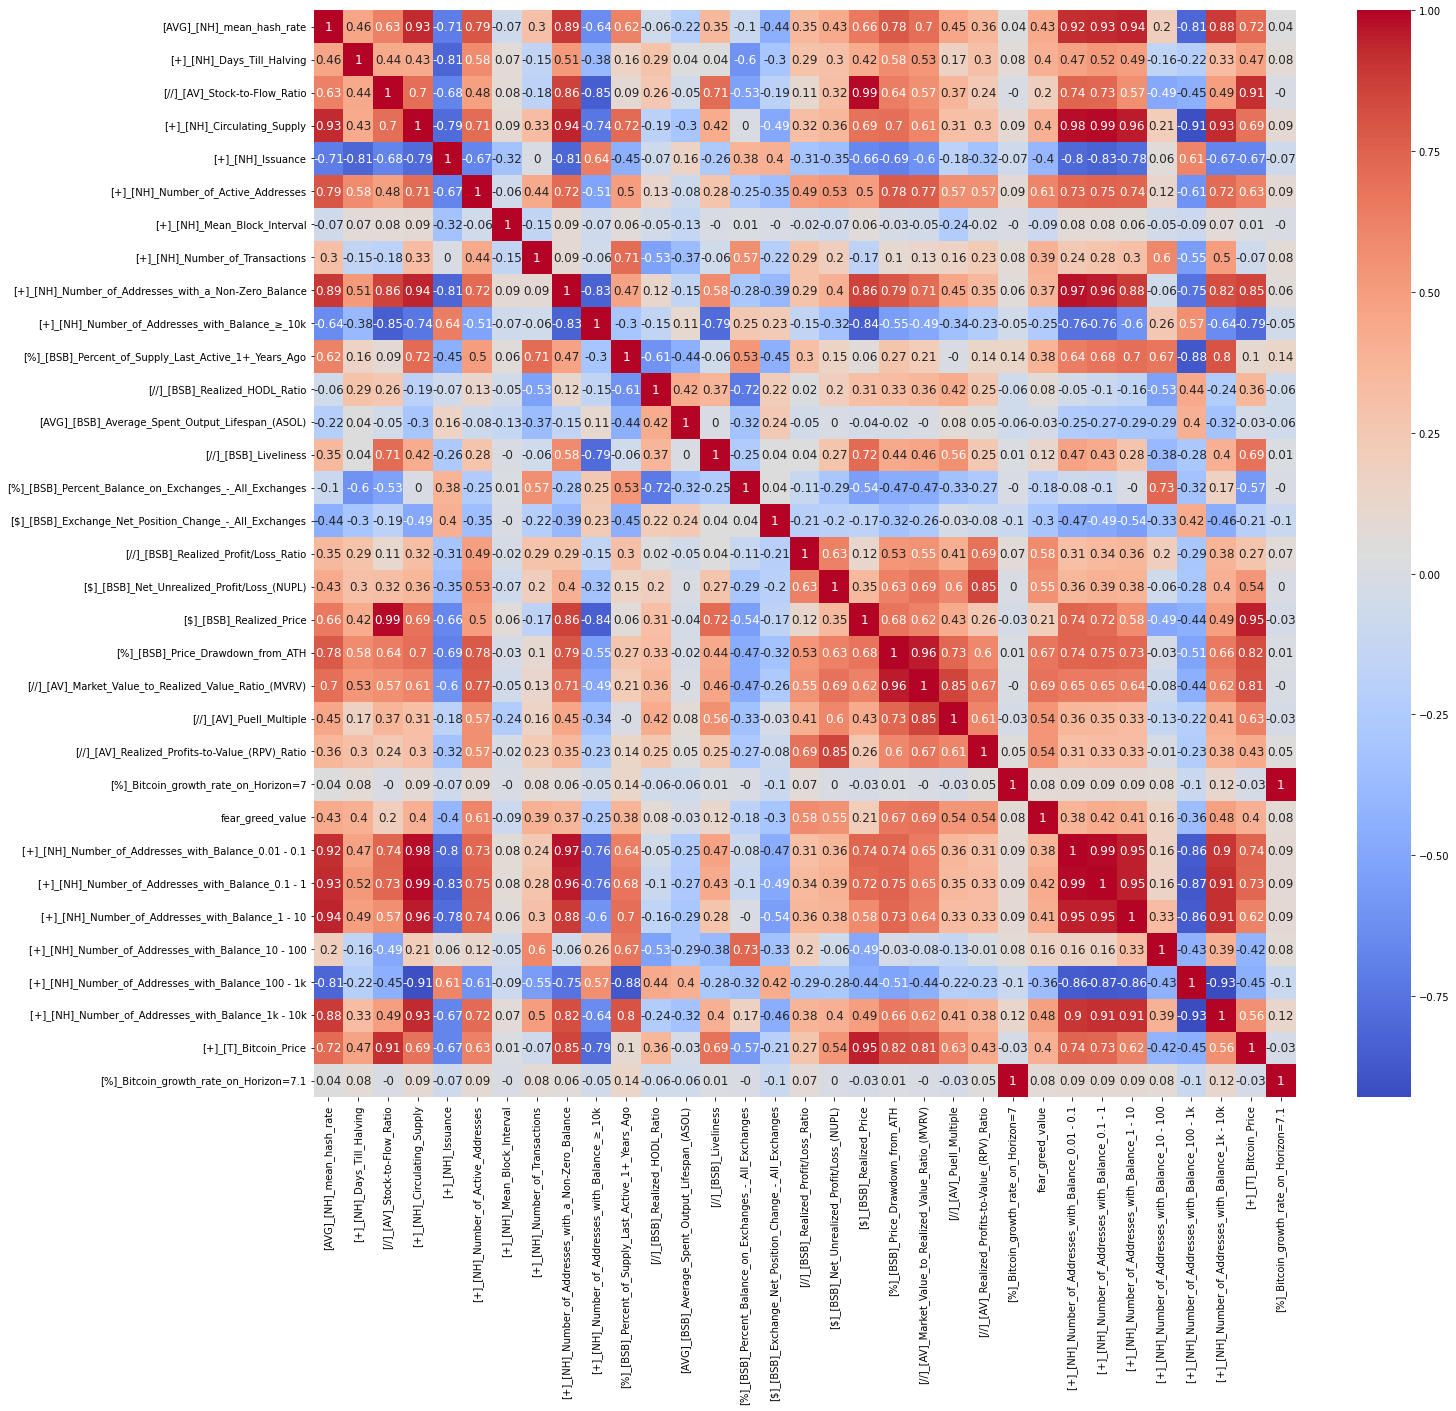

In [22]:
plt.figure(figsize = (22,20))
sns.heatmap(round(train_df.corr(),2), cmap = "coolwarm", annot = True, annot_kws = {"size":12});

In [23]:
train_df.corr().style.background_gradient(cmap='coolwarm')

,[AVG]_[NH]_mean_hash_rate,[+]_[NH]_Days_Till_Halving,[//]_[AV]_Stock-to-Flow_Ratio,[+]_[NH]_Circulating_Supply,[+]_[NH]_Issuance,[+]_[NH]_Number_of_Active_Addresses,[+]_[NH]_Mean_Block_Interval,[+]_[NH]_Number_of_Transactions,[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance,[+]_[NH]_Number_of_Addresses_with_Balance_≥_10k,[%]_[BSB]_Percent_of_Supply_Last_Active_1+_Years_Ago,[//]_[BSB]_Realized_HODL_Ratio,[AVG]_[BSB]_Average_Spent_Output_Lifespan_(ASOL),[//]_[BSB]_Liveliness,[%]_[BSB]_Percent_Balance_on_Exchanges_-_All_Exchanges,[$]_[BSB]_Exchange_Net_Position_Change_-_All_Exchanges,[//]_[BSB]_Realized_Profit/Loss_Ratio,[$]_[BSB]_Net_Unrealized_Profit/Loss_(NUPL),[$]_[BSB]_Realized_Price,[%]_[BSB]_Price_Drawdown_from_ATH,[//]_[AV]_Market_Value_to_Realized_Value_Ratio_(MVRV),[//]_[AV]_Puell_Multiple,[//]_[AV]_Realized_Profits-to-Value_(RPV)_Ratio,[%]_Bitcoin_growth_rate_on_Horizon=7,fear_greed_value,[+]_[NH]_Number_of_Addresses_with_Balance_0.01 - 0.1,[+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1,[+]_[NH]_Number_of_Addresses_with_Balance_1 - 10,[+]_[NH]_Number_of_Addresses_with_Balance_10 - 100,[+]_[NH]_Number_of_Addresses_with_Balance_100 - 1k,[+]_[NH]_Number_of_Addresses_with_Balance_1k - 10k,[+]_[T]_Bitcoin_Price,[%]_Bitcoin_growth_rate_on_Horizon=7.1
[AVG]_[NH]_mean_hash_rate,1.000000,0.463249,0.629304,0.927169,-0.712801,0.786284,-0.074117,0.302058,0.891591,-0.642719,0.618775,-0.064499,-0.223473,0.346633,-0.099812,-0.436845,0.352598,0.430237,0.658344,0.780710,0.701607,0.454708,0.364717,0.040287,0.425569,0.918749,0.930605,0.943424,0.195707,-0.805297,0.875414,0.719440,0.040287
[+]_[NH]_Days_Till_Halving,0.463249,1.000000,0.436866,0.429619,-0.806056,0.578606,0.065288,-0.149963,0.509130,-0.375290,0.157318,0.289647,0.043345,0.035987,-0.600236,-0.301690,0.293135,0.304622,0.421928,0.576445,0.527764,0.167966,0.303928,0.078466,0.400436,0.468366,0.524204,0.490842,-0.161942,-0.221015,0.328016,0.468988,0.078466
[//]_[AV]_Stock-to-Flow_Ratio,0.629304,0.436866,1.000000,0.699114,-0.677327,0.480246,0.079940,-0.175754,0.862252,-0.854818,0.093373,0.263993,-0.049393,0.706719,-0.526405,-0.188825,0.111765,0.315212,0.987655,0.641723,0.567439,0.371786,0.236555,-0.002152,0.199319,0.740555,0.728599,0.567451,-0.491705,-0.454533,0.488206,0.906993,-0.002152
[+]_[NH]_Circulating_Supply,0.927169,0.429619,0.699114,1.000000,-0.785888,0.713864,0.086502,0.326340,0.937225,-0.742942,0.722878,-0.187891,-0.300747,0.416767,0.003272,-0.487680,0.321386,0.363360,0.692426,0.700705,0.606142,0.311548,0.303061,0.085130,0.397213,0.983180,0.988814,0.956500,0.213877,-0.910185,0.927949,0.692385,0.085130
[+]_[NH]_Issuance,-0.712801,-0.806056,-0.677327,-0.785888,1.000000,-0.667848,-0.320468,0.001851,-0.811983,0.642440,-0.448837,-0.071333,0.158610,-0.263890,0.376395,0.403325,-0.307613,-0.348303,-0.661773,-0.685477,-0.601245,-0.176188,-0.320841,-0.072187,-0.395923,-0.796370,-0.833541,-0.777053,0.062784,0.611022,-0.672405,-0.668343,-0.072187
[+]_[NH]_Number_of_Active_Addresses,0.786284,0.578606,0.480246,0.713864,-0.667848,1.000000,-0.056850,0.435982,0.721753,-0.507995,0.502994,0.127484,-0.075966,0.277955,-0.250108,-0.352278,0.490178,0.530244,0.501975,0.777829,0.767619,0.568422,0.568438,0.085660,0.608574,0.727494,0.752606,0.742655,0.117773,-0.605229,0.724160,0.630475,0.085660
[+]_[NH]_Mean_Block_Interval,-0.074117,0.065288,0.079940,0.086502,-0.320468,-0.056850,1.000000,-0.151192,0.086153,-0.065260,0.060282,-0.048855,-0.127782,-0.002470,0.006885,-0.003950,-0.022173,-0.070328,0.062122,-0.031807,-0.048268,-0.236834,-0.023886,-0.003636,-0.088705,0.080949,0.082551,0.063097,-0.053289,-0.085351,0.067485,0.013416,-0.003636
[+]_[NH]_Number_of_Transactions,0.302058,-0.149963,-0.175754,0.326340,0.001851,0.435982,-0.151192,1.000000,0.094851,-0.060986,0.710054,-0.530734,-0.369053,-0.064918,0.573600,-0.216038,0.286636,0.204831,-0.173771,0.100305,0.127494,0.161846,0.231068,0.077359,0.391888,0.242317,0.277630,0.299953,0.597648,-0.553077,0.500145,-0.067909,0.077359
[+]_[NH]_Number_of_Addr

## Defining Dummy model as baseline

In [24]:
# Instanciate model
dummy_model = DummyModel()
# Train and Fit data using the crossval
train(dummy_model,train_df)

100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.26it/s]

Training done


([104443796.71409,
  136894896.907,
  57789826.1821,
  57571948.57084,
  36307411.5702,
  74567013.08173,
  80072777.50872,
  72418172.60801,
  59181788.0284,
  51308205.40128,
  60591021.98488,
  32626648.07279,
  40880308.76564,
  31323988.01489,
  43549913.06879,
  54124421.99118,
  85738756.0788,
  83004849.74182,
  73315649.9243,
  39252052.61965,
  43965416.36385,
  71334913.00391,
  79765432.61877,
  147999557.83168,
  158509296.47573,
  174562435.88332,
  203875202.18098,
  201701888.36384,
  223167206.73096,
  285640794.51113,
  278941967.31325,
  304205981.32192],
 107769798.10733)

## Elastic Net Tuning

In [25]:
# Instanciate Grid Search
for counter in range(10):
    alpha = 50 * random()
    l1 = 0.001
    # Instanciate model
    regression_model = LinearRegressionBaselineModel(alpha = alpha, l1_ratio = l1)
    # Train and Fit data using the crossval
    train(regression_model,train_df)

100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 14.91it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 15.04it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 15.11it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 15.04it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 15.07it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 15.09it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 15.07it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 15.07it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 15.06it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 15.04it/s]

Training done


## RNN tuning

In [28]:
# Instanciate Grid Search
for counter in range(1):
    l1 = random() / 10
    l2 = random() / 10
    # Instanciate model
    rnn_model = RnnDlModel(L1 = l1, L2 = l2, epochs = 2, patience = 10)
    # Train and Fit data using the crossval
    fold_score, score = train(rnn_model,train_df)

100%|███████████████████████████████████████████| 32/32 [01:56<00:00,  3.64s/it]

Training done


In [29]:
print(fold_score, score)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] nan


## Exporting and viewing results

In [30]:
df_result = read_result()
df_result.sort_values(by="mean_score", ascending = False)

,name,fold_score,mean_score,min_score,max_score,hyperparams,date
15,Dummy,"[104443796.71409, 136894896.907, 57789826.1821...",1.077698e+08,3.132399e+07,3.042060e+08,NaN,08-03 11:03:45
1,Dummy,"[104443796.71409, 136894896.907, 57789826.1821...",1.077698e+08,3.132399e+07,3.042060e+08,NaN,08-03 11:02:20
0,LinearReg,"[854.24552, 622.42861, 493.03903, 216.84037, 4...",4.092938e+02,1.168868e+02,1.708942e+03,"{'alpha': 0.1, 'l1_ratio': 0.001}",08-03 11:02:14
14,LinearReg,"[854.24552, 622.42861, 493.03903, 216.84037, 4...",4.092938e+02,1.168868e+02,1.708942e+03,"{'alpha': 0.1, 'l1_ratio': 0.001}",08-03 11:03:39
21,LinearReg,"[825.38041, 688.86639, 208.91283, 156.25223, 1...",1.879553e+02,9.653568e+01,8.253804e+02,"{'alpha': 26.48286261231705, 'l1_ratio': 0.001}",08-03 11:03:58
20,LinearReg,"[825.38041, 688.86639, 208.91283, 156.25223, 1...",1.879553e+02,9.653568e+01,8.253804e+02,"{'alpha': 26.559064262705206, 'l1_ratio': 0.001}",08-03 11:03:56
16,LinearReg,"[825.38041, 688.86639, 208.91283, 156.25223, 1...",1.879553e+02,9.653568e+01,8.253804e+02,"{'alpha': 26.63228447585158, 'l1_ratio': 0.001}",08-03 11:03:47
12,LinearReg,"[825.38041, 688.86639, 208.91283, 156.25223, 1...",1.879553e+02,9.653568e+01,8.253804e+02,"{'alpha': 21.10384470374208, 'l1_ratio': 0.001}",08-03 11:02:44
11,LinearReg,"[825.38041, 688.86639, 208.91283, 156.25223, 1...",1.879553e+02,9.653568e+01,8.253804e+02,"{'alpha': 25.327487599672015, 'l1_ratio': 0.001}",08-03 11:02:41
9,LinearReg,"[825.38041, 688.86639, 208.91283, 156.25223, 1...",1.879553e+02,9.653568e+01,8.253804e+02,"{'alpha': 27.354675224599617, 'l1_ratio': 0.001}",08-03 11:02:37


## Notes

In [ ]:
# take mean on the week on linear regression and inspect the weights
# create a btc trajectory on linear trend +2% (test unitaire) => check outcome of strategies in a basic situation
# y_diff to try to improve MAPE
# Check colinearity on coefficients => heatmap ?
# RNN, can try with less features from 2015 if we lack of simples (263 sized sequences, might not be enough)
# l1 is a feature selector that can help tune the RNN
#Feature importance
#if you don't have enough variance, you can leave them out
#Vif analysis on X
#checking the y permutation importance (suffling and checking impact on R2)
#Reco => vif on features & lasso importance
#shuffle on each folds axis = 0 np.array.shuffle()

#keep the mae of the y_diff
#Redo the coeffs
#Finetuning of the models
#plotting distribution of the mae as well